## Resolution analysis of XGBRegressor 

- **Data**:
    - All the events including both pions and muons
- **Model type**: 
    - Regressor 
- **Engineered features**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points
- **Preprocessing**:
    - Only the in-time hits where delta <= 0.5 are included 

## Imports

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import glob
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pyarrow 

## Read the data and train-test split

In [2]:
# Read in parquet files and drop NAs 
df_selected = pd.read_parquet('../../data/events_with_hit_features_[cut_off_time=0.5].parquet').dropna()

# Filter for muons only for the training set
df_muons = df_selected.query('`class`== "muon"')

# Train test split (muon data)
train_df, test_df_muon = train_test_split(df_muons, random_state=42)

# Append pion data to the test set 
test_df = pd.concat([test_df_muon, df_selected.query('`class`== "pion"')])

# Define X and y
X_train = train_df.iloc[:, 1:19]
y_train = train_df['ring_radius_cal']
X_test = test_df.iloc[:, 1:19]
y_test = test_df['ring_radius_cal']

## Fit XGBRegressor

In [3]:
# Define the model
xgb_reg = xgb.XGBRegressor()
# Fit the model
xgb_reg.fit(X_train, y_train)

test_result = test_df.copy()

## Predict on the entire dataset

In [4]:
# Predict on the entire dataset
test_result['radius_pred'] = xgb_reg.predict(test_result.iloc[:, 1:19])

In [5]:
# Describe the test result 
test_result['track_momentum'].describe()

count    755306.000000
mean         36.143753
std          12.013361
min           9.442538
25%          27.424381
50%          35.071695
75%          43.918932
max          74.378830
Name: track_momentum, dtype: float64

## 1. Resolution analysis for XGBRegressor

### 1.1 Show distribution of predicted radii of pions and muons in each momentum bin of XGBRegressor
- Data was broken down to 34 momentum bins, each bin size of 2 GeV/c
- Momentum ranges from 9.44 to 75.55 GeV/c
- In each momentum bin,  the distribution of predicted radii of pion and muon are compared 
- A good resolution should be reflected by a clear separation between the distributions 
- We should find out which momentum bin gives the best separation



In [6]:
# Cut the momentum bins 
bins = np.arange(9, 76, 1)
test_result['momentum_bin'] = pd.cut(test_result['track_momentum'], bins=bins)

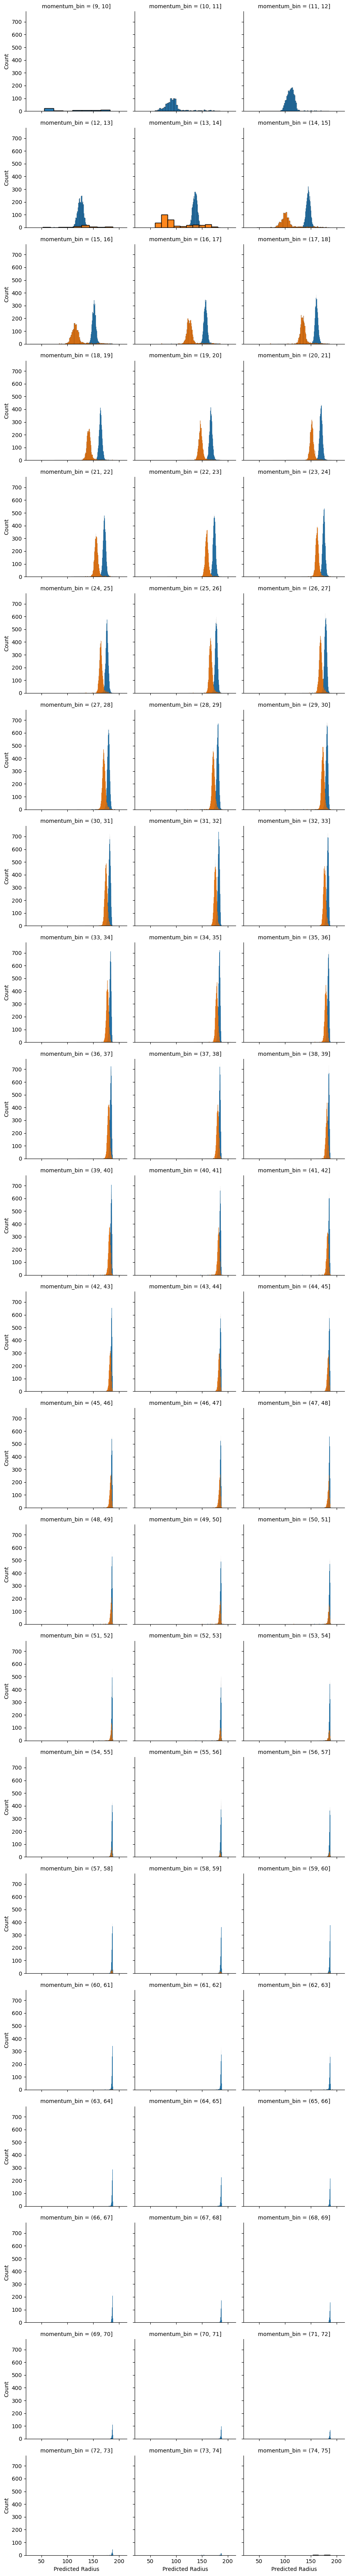

In [7]:
# Show the distribution of muons and pions in each momentum bin

g = sns.FacetGrid(test_result, col='momentum_bin', col_wrap=3, hue='class')
g.map(sns.histplot, 'radius_pred', fill=True)
g.map(sns.histplot, 'radius_pred', lw=1)

g.set_axis_labels('Predicted Radius', 'Count')

plt.tight_layout()

plt.show()


**Note**:
- Blue: muon
- Orange: pion
- Can see that the separation is most clear when momentum is between 13 and 15 GeV/c
- The two distributions start to come closer afterwards
- The peak are not “separatable” starting from ~ 23 GeV/c



### 1.2 Show numbers of muons and pions in each momentum bin (XGBRegressor)

In [8]:
# Count the number of muons and pions in each momentum bin
counts = test_result.groupby('momentum_bin')['class'].value_counts().unstack()

In [9]:
# Show the first 60 rows in the order of momentum bins 
counts.head(60)

class,muon,pion
momentum_bin,,
"(9, 10]",58,0
"(10, 11]",835,0
"(11, 12]",2271,0
"(12, 13]",3240,52
"(13, 14]",4041,303
"(14, 15]",4532,1014
"(15, 16]",4915,1725
"(16, 17]",5383,2389
"(17, 18]",6196,2830


### 1.3 Find the 2.5% quantile of muons and 97.5% quantile of pions in each bin (XGBRegressor)

- To calculate resolution, the difference between the 2.5% quantile of muon and 97.5% quantile of pion is calculated 

In [10]:
# Compute the mean and standard deviation for every momentum bin
stat_pred = pd.DataFrame(test_result.groupby(['momentum_bin', 'class']).aggregate({'radius_pred': ['mean', 'std']}))
stat_pred = stat_pred.dropna()
stat_pred = stat_pred.reset_index()
stat_pred.columns = ['momentum_bin', 'class', 'mean', 'std']

In [11]:
# Calculate the 2.5% and 97.5% quantiles 
stat_pred['2_5'] = stat_pred['mean'] - 2 * stat_pred['std']
stat_pred['97_5'] = stat_pred['mean'] + 2 * stat_pred['std']

### 1.4 Calculate the resolution (2.5% quantile of muons - 97.5% of pions) (XGBRegressor)

In [12]:
# Mapping of class names to numeric values
class_mapping = {'pion': 0, 'muon': 1}

# Map the 'class' column to numeric values using the class_mapping 
stat_pred['class_numeric'] = stat_pred['class'].map(class_mapping)

# Select rows where the class column is 'pion' and group by momentum_bin
# Calculate the quantiles (0.025 and 0.975) of the 'mean' column and unstack the result
pion_quantiles = stat_pred[stat_pred['class'] == 'pion'].groupby('momentum_bin')['mean'].quantile([0.025, 0.975]).unstack()

# Select rows where the class column is muon and group by momentum_bin
# Calculate the quantiles (0.025 and 0.975) of the 'mean' column and unstack the result
muon_quantiles = stat_pred[stat_pred['class'] == 'muon'].groupby('momentum_bin')['mean'].quantile([0.025, 0.975]).unstack()

# Create an empty dataframe to store the differences between muon and pion quantiles
quantiles = pd.DataFrame()

# Calculate the difference between the muon and pion quantiles (0.025) and store it in the difference column
quantiles['difference'] = muon_quantiles[0.025] - pion_quantiles[0.975]


In [13]:
# Pivot the stat_pred DataFrame with momentum_bin as the index and class as the columns
pivoted_df = stat_pred.pivot(index='momentum_bin', columns='class')

# Calculate the difference between the muon values at the 2.5% column and the pion values at the 97.5% column
difference = pivoted_df['2_5', 'muon'] - pivoted_df['97_5', 'pion']

# Create a new dataframe called with the difference
result_df = pd.DataFrame({'difference': difference})


In [14]:
# Reset index
result_df = result_df.reset_index()

In [15]:
# Show the difference between 2.5% quantile of pion distribution and 97.5% quantile of muon distribution by descending order 
result_df.sort_values(by='difference', ascending=False).head(10)

,momentum_bin,difference
7,"(16, 17]",3.356881
9,"(18, 19]",2.306397
8,"(17, 18]",2.150777
6,"(15, 16]",1.630515
10,"(19, 20]",1.379365
11,"(20, 21]",0.655615
12,"(21, 22]",-0.727183
14,"(23, 24]",-1.054888
13,"(22, 23]",-1.135193
15,"(24, 25]",-2.062534


## 2. Resolution analysis for state-of-the-art method (SOTA)

### 2.1 Find the 2.5% quantile of muons and 97.5% quantile of pions in each bin (SOTA)

In [16]:
# Compute the mean and standard deviation for every momentum bin
stat_sota = pd.DataFrame(test_result.query('ring_radius<=1000').groupby(['momentum_bin', 'class']).aggregate({'ring_radius': ['mean', 'std']}))
stat_sota = stat_sota.dropna()
stat_sota = stat_sota.reset_index()
stat_sota.columns = ['momentum_bin', 'class', 'mean', 'std']

In [17]:
# Calculate the 2.5% and 97.5% quantiles 
stat_sota['2_5'] = stat_sota['mean'] - 2 * stat_sota['std']
stat_sota['97_5'] = stat_sota['mean'] + 2 * stat_sota['std']

### Calculate the resolution (2.5% quantile of muons - 97.5% of pions) (SOTA)

In [18]:
# Mapping of class names to numeric values
class_mapping = {'pion': 0, 'muon': 1}

# Map the 'class' column to numeric values using the class_mapping
stat_sota['class_numeric'] = stat_sota['class'].map(class_mapping)

# Select rows where the class column is 'pion' and group by momentum_bin
# Calculate the quantiles (0.025 and 0.975) of the 'mean' column and unstack the result
pion_quantiles = stat_sota[stat_sota['class'] == 'pion'].groupby('momentum_bin')['mean'].quantile([0.025, 0.975]).unstack()

# Select rows where the class column is muon and group by momentum_bin
# Calculate the quantiles (0.025 and 0.975) of the 'mean' column and unstack the result
muon_quantiles = stat_sota[stat_sota['class'] == 'muon'].groupby('momentum_bin')['mean'].quantile([0.025, 0.975]).unstack()

# Create an empty dataframe to store the differences between muon and pion quantiles
quantiles = pd.DataFrame()

# Calculate the difference between the muon and pion quantiles (0.025) and store it in the difference column
quantiles['difference'] = muon_quantiles[0.025] - pion_quantiles[0.975]


In [19]:
# Pivot the stat_pred DataFrame with momentum_bin as the index and class as the columns
pivoted_df_sota = stat_sota.pivot(index='momentum_bin', columns='class')

# Calculate the difference between the muon values at the 2.5% column and the pion values at the 97.5% column
difference_sota = pivoted_df_sota['2_5', 'muon'] - pivoted_df_sota['97_5', 'pion']

# Create a new dataframe called with the difference
result_df_sota = pd.DataFrame({'difference': difference_sota})

In [20]:
# Reset index
result_df_sota = result_df_sota.reset_index()
# Show the difference between 2.5% quantile of pion distribution and 97.5% quantile of muon distribution by descending order 
result_df_sota.sort_values(by='difference', ascending=False).head(10)

,momentum_bin,difference
5,"(14, 15]",5.115926
6,"(15, 16]",-0.221073
4,"(13, 14]",-3.877510
19,"(28, 29]",-4.892311
16,"(25, 26]",-6.415118
14,"(23, 24]",-6.583318
17,"(26, 27]",-7.111299
8,"(17, 18]",-8.418143
25,"(34, 35]",-8.738337
52,"(61, 62]",-8.908766


## 3. Compare the FPR of muons at 97.5% quantile of pions between XGBRegressor and SOTA

In [21]:
# Get unique values of momentum_bin 
momentum_bins = test_result['momentum_bin'].unique()

# Initialize empty lists to store results
decision_boundaries = []
decision_boundaries_sota = []
fprs = []
fprs_sota = []

# Iterate over each momentum bin
for momentum_bin in momentum_bins:
    # Filter the test_result by the current momentum bin
    filtered_df = test_result[test_result['momentum_bin'] == momentum_bin]

    # Group by class
    grouped_df = filtered_df.groupby('class')

    # Calculate the 0.975 quantile of sota predicted radius for each class
    quantile_975 = grouped_df['radius_pred'].quantile(0.975)

    # Calculate the 0.975 quantile of xgb predicted radius for each class
    quantile_975_sota = grouped_df['ring_radius'].quantile(0.975)

    # Get the decision boundary for the pion class from quantile_975
    decision_boundary = quantile_975.get('pion')

    # Get the decision boundary for the pion class from quantile_975_sota
    decision_boundary_sota = quantile_975_sota.get('pion')

    # Handle cases where decision boundaries are not found
    if decision_boundary is None:
        decision_boundary = np.nan

    if decision_boundary_sota is None:
        decision_boundary_sota = np.nan

    # Append decision boundaries to the respective lists
    decision_boundaries.append(decision_boundary)
    decision_boundaries_sota.append(decision_boundary_sota)

    # Filter for muons based on the decision boundary
    filtered_muons = filtered_df[(filtered_df['class'] == 'muon') & (filtered_df['radius_pred'] < decision_boundary)]

    filtered_muons_sota = filtered_df[(filtered_df['class'] == 'muon') & (filtered_df['ring_radius'] < decision_boundary_sota)]

    # Calculate the FPR for the filtered muon data
    fpr = filtered_muons.shape[0] / filtered_df[filtered_df['class'] == 'muon'].shape[0]

    fpr_sota = filtered_muons_sota.shape[0] / filtered_df[filtered_df['class'] == 'muon'].shape[0]

    # Append FPRs to the respective lists
    fprs.append(fpr)
    fprs_sota.append(fpr_sota)

# Create a DataFrame with the results
result_df = pd.DataFrame({'momentum_bin': momentum_bins, 'decision_boundary': decision_boundaries, 'fpr': fprs, 'fpr_sota': fprs_sota})


In [22]:
# Sort the FPR in ascending order by momentum bin
result_df.sort_values(by='momentum_bin').head(60)

,momentum_bin,decision_boundary,fpr,fpr_sota
64,"(9, 10]",NaN,0.000000,0.000000
53,"(10, 11]",NaN,0.000000,0.000000
61,"(11, 12]",NaN,0.000000,0.000000
35,"(12, 13]",179.980642,0.997222,0.994444
1,"(13, 14]",167.066393,0.995793,0.993566
38,"(14, 15]",159.888702,0.988305,0.758605
4,"(15, 16]",159.189140,0.972126,0.003866
12,"(16, 17]",158.376215,0.666171,0.052759
22,"(17, 18]",159.852214,0.335862,0.007747
42,"(18, 19]",160.129628,0.068318,0.058559


## 4. Plot the muons FPR vs. quantiles in each momentum bin for XGBRegressor and SOTA

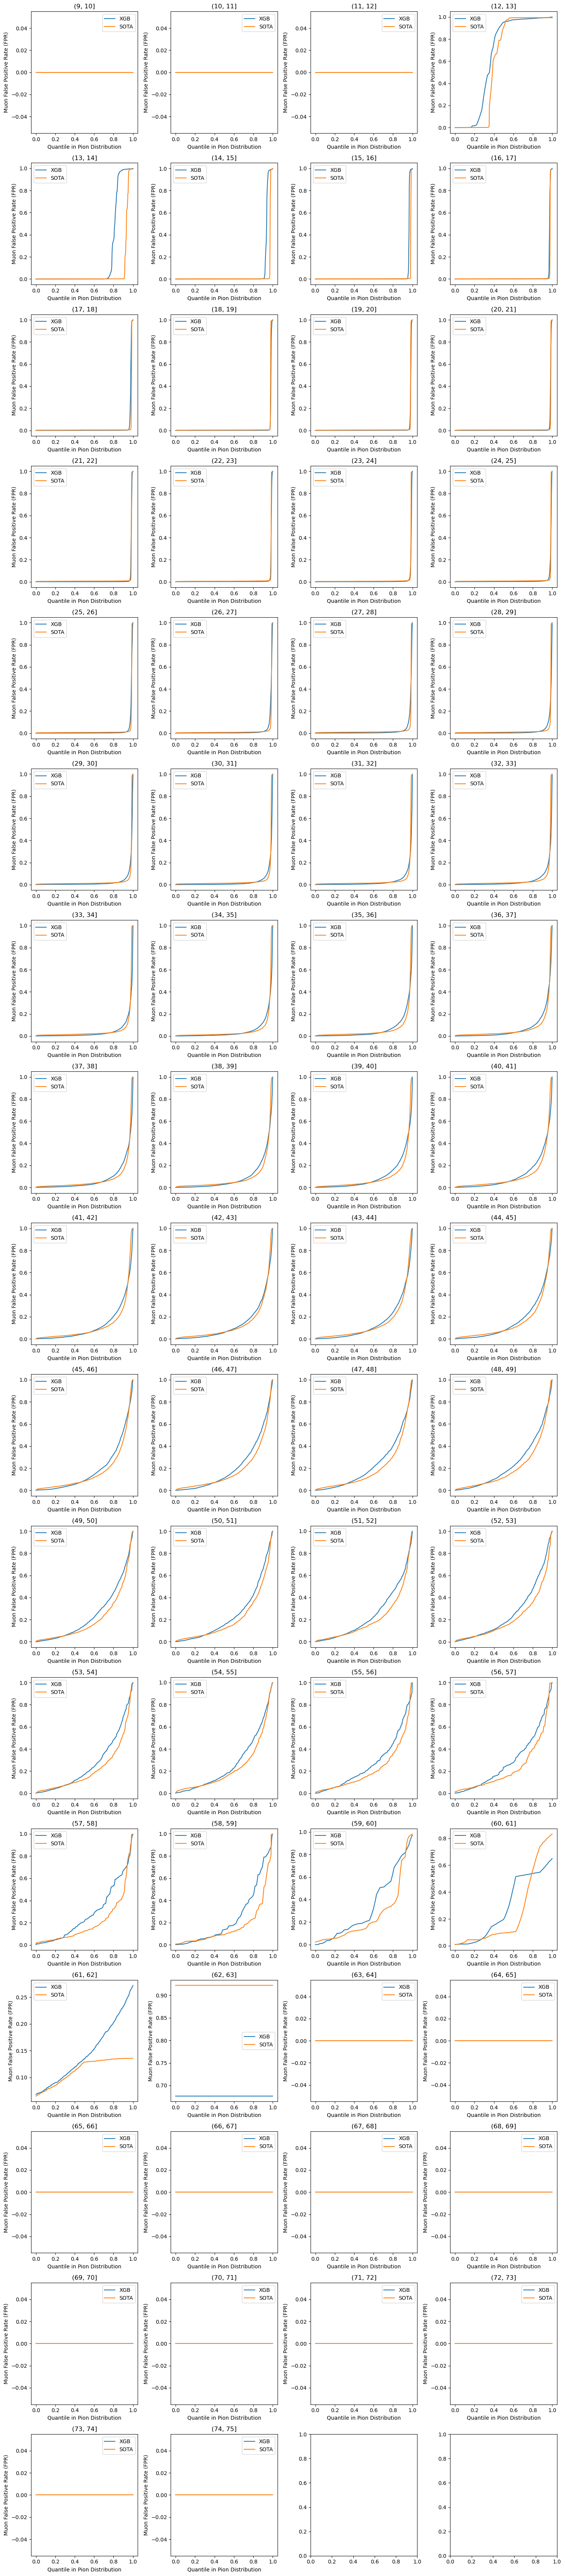

In [23]:
# Get unique momentum bin values 
momentum_bins = test_result['momentum_bin'].sort_values().unique()

# Calculate the number of rows and columns for the subplot grid
num_rows = (len(momentum_bins) + 3) // 4
num_cols = min(len(momentum_bins), 4)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
axes = axes.flatten()

# Iterate over each momentum bin
for i, momentum_bin in enumerate(momentum_bins):
    # Filter the for the current momentum bin
    filtered_df = test_result[test_result['momentum_bin'] == momentum_bin]

    # Filter for muon and pion data separately
    filtered_muons = filtered_df[filtered_df['class'] == 'muon']
    filtered_pions = filtered_df[filtered_df['class'] == 'pion']

    # Define quantiles for calculating decision boundaries
    quantiles = np.linspace(0, 1, num=400)

    # Calculate decision boundaries for radius_pred and ring_radius in the pion data
    decision_boundaries = filtered_pions['radius_pred'].quantile(quantiles)
    decision_boundaries_sota = filtered_pions['ring_radius'].quantile(quantiles)

    # Initialize lists to store FPR values for radius_pred and ring_radius
    fprs_pred = []
    fprs_ring = []

    # Calculate FPR for muons at each decision boundary for radius_pred
    for decision_boundary in decision_boundaries:
        filtered_below_boundary = filtered_muons[filtered_muons['radius_pred'] < decision_boundary]
        fpr_pred = filtered_below_boundary.shape[0] / filtered_muons.shape[0]
        fprs_pred.append(fpr_pred)

    # Calculate FPR for muons at each decision boundary for ring_radius
    for decision_boundary in decision_boundaries_sota:
        filtered_below_boundary = filtered_muons[filtered_muons['ring_radius'] < decision_boundary]
        fpr_ring = filtered_below_boundary.shape[0] / filtered_muons.shape[0]
        fprs_ring.append(fpr_ring)

    # Create dataframes with quantiles and FPR values for radius_pred and ring_radius
    data_pred = pd.DataFrame({'Quantile': quantiles, 'Muon FPR (radius_pred)': fprs_pred})
    data_ring = pd.DataFrame({'Quantile': quantiles, 'Muon FPR (ring_radius)': fprs_ring})

    # Select the appropriate subplot and plot the lines
    ax = axes[i]
    sns.lineplot(data=data_pred, x='Quantile', y='Muon FPR (radius_pred)', ax=ax, label='XGB')
    sns.lineplot(data=data_ring, x='Quantile', y='Muon FPR (ring_radius)', ax=ax, label='SOTA')

    # Set labels and title for the subplot
    ax.set_xlabel('Quantile in Pion Distribution')
    ax.set_ylabel('Muon False Positive Rate (FPR)')
    ax.set_title(f'{momentum_bin}')
    ax.legend()

# Adjust the layout of the subplots
plt.tight_layout()



## 5. Conclusion

- The XGBRegressor model shows comparable performance to SOTA at lower momentum range (up to 24-25 GeV/c)
- The SOTA outperforms the XGBRegressor for higher momentum range (higher than 25 GeV/c)